In [294]:
import pandas as pd
from src.constants import OUTPUT_PATH
import os
import seaborn as sns
from matplotlib import pyplot as plt

USER = os.environ["USER"]
PROJECT_HOME = f"/home/{USER}/projects/feedback-DT"

In [295]:
def get_experiments(output_path, dir):
    settings = dir.split("-")[5:]
    dfs = []
    for seed_dir in os.listdir(os.path.join(output_path, dir)):
        exp_path = os.path.join(output_path, os.path.join(dir, seed_dir))
        try:
            df = pd.read_pickle(os.path.join(exp_path, "results.pkl"))
            df["seed"] = seed_dir
        except:
            continue
        for s in settings:
            param = s.split("_")[:-1]
            param ="_".join(param)
            value = s.split("_")[-1]
            value = int(value) if value.isnumeric() else (True if value == "True" else (False if value == "False" else value))
            df[param] = value
        try:
            df["feedback"] = df.apply(lambda row: "no" if row["use_feedback"] == False else row["feedback_mode"], axis=1)
            df["mission"] = df.apply(lambda row: "no" if row["use_mission"] == False else "yes", axis=1)
            df["rtg"] = df.apply(lambda row: "no" if row["use_rtg"] == False else "yes", axis=1)
            df["conditioning"] = "mission" + "_" + df["mission"] + "_" + "feedback" + "_" + df["feedback"] + "_" + "rtg" + "_" + df["rtg"]
        except KeyError:
            pass
        try:
            df["random"] = df.apply(lambda row: "random" + "_" + row["random_mode"] if row["feedback_mode"] == "random" else "random_no", axis=1)
            df["conditioning"] = df["conditioning"] + "_" + df["random"]
        except KeyError:
            pass
        try:
            df["num_eps"] = df["eps_per_seed"] * df["num_train_seeds"]
        except KeyError:
            pass
        try:
            df["eps_per_seed_num_train_seeds"] = df["eps_per_seed"].astype(str) + "_" + df["num_train_seeds"].astype(str)
        except KeyError:
            pass
        try:
            df["inference"] = "mission" + "_" + df["mission_at_inference"]
        except KeyError:
            try:
                df["inference"] = "feedback" + "_" + df["feedback_at_inference"]
            except:
                pass
        dfs.append(df)
    return dfs

def get_combined_df(output_path):
    dfs = []
    for dir in os.listdir(output_path):
        if "level" in dir and not "seed" in dir:
            current_dfs = get_experiments(output_path, dir)
            dfs.extend(current_dfs)
    dfs = [df[(df["eval_type"] != "efficiency") & (df["model"] == "DT")] for df in dfs]
    comb_df = pd.concat(dfs, ignore_index=True)
    return comb_df

In [296]:
def plot_iid(level, level_df, param, metric, output_path):
    iid_df = level_df[level_df["eval_type"] == "iid_generalisation"]
    result = iid_df.groupby([param])[metric].aggregate('mean').reset_index().sort_values(metric, ascending=False)
    plt.figure()        
    ax1 = sns.barplot(x=param, y=metric, data=iid_df, order=result[param])
    plt.xticks(rotation=90)
    plt.title(f"IID generalisation on {level}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path,f"iid_generalisation_{level}_{param}_{metric}.png"))
    plt.show()
    print("SAVED FIG")

def plot_ood(level, level_df, param, metric, output_path):
    # ood_df = level_df[level_df["eval_type"] == "ood_generalisation"][[param, metric, "ood_type"]].groupby([param, "ood_type"]).mean().reset_index()
    ood_df = level_df[level_df["eval_type"] == "ood_generalisation"]
    result = ood_df.groupby([param])[metric].aggregate('mean').reset_index().sort_values(metric, ascending=False)
    plt.figure()
    ax = sns.barplot(x=param, y=metric, hue="ood_type", data=ood_df, order=result[param])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.title(f"OOD generalisation on {level}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path,f"ood_generalisation_{level}_{param}_{metric}.png"))
    plt.show()
    print("SAVED FIG")

def plot_levels(output_path, params, metric, comb_df):
    for level in comb_df["level"].unique():
        level_df = comb_df[comb_df["level"] == level]
        for param in params:
            plot_iid(level, level_df, param, metric, output_path)
            plot_ood(level, level_df, param, metric, output_path)

In [297]:
def make_table_ood_type(ood_df, level, param, metric, output_path):
    results = ood_df[[param, "ood_type", metric]].groupby([param, "ood_type"]).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values(["ood_type", "Mean"], ascending=False)
    path = os.path.join(output_path,f"ood_generalisation_{level}_{param}_{"ood_type"}_{metric}.csv")
    results.to_csv(path)
    display(results)
    print("CREATED TABLE IN CSV")

def make_table_seeds(df, param, metric):
    results = df[[param, "seed", metric]].groupby([param, "seed"]).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values(["seed", "Mean"], ascending=False)
    print("Results by seed")
    display(results)

def make_table_iid(level, level_df, param, metric, output_path):
    iid_df = level_df[level_df["eval_type"] == "iid_generalisation"]
    results = iid_df[[param, metric]].groupby(param).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values("Mean", ascending=False)
    path = os.path.join(output_path,f"iid_generalisation_{level}_{param}_{metric}.csv")
    results.to_csv(path)
    display(results)
    print("CREATED TABLE IN CSV")
    make_table_seeds(iid_df, param, metric)

def make_table_ood(level, level_df, param, metric, output_path):
    ood_df = level_df[level_df["eval_type"] == "ood_generalisation"]
    results = ood_df[[param, metric]].groupby(param).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values("Mean", ascending=False)
    path = os.path.join(output_path,f"ood_generalisation_{level}_{param}_{metric}.csv")
    results.to_csv(path)
    display(results)
    print("CREATED TABLE IN CSV")
    make_table_ood_type(ood_df, level, param, metric, output_path)
    make_table_seeds(ood_df, param, metric)

def make_tables(output_path, params, metric, comb_df):
    for level in comb_df["level"].unique():
        level_df = comb_df[comb_df["level"] == level]
        for param in params:
            make_table_iid(level, level_df, param, metric, output_path)
            make_table_ood(level, level_df, param, metric, output_path)

In [298]:
# Experiment names should correspond to the folder name
EXPERIMENT_NAMES = [
    # "random_start_or_from_end", 
    # "num_seeds_vs_eps_per_seed", 
    # "loss_mean", 
    # "ep_distribution",
    # "mission_at_inference",
    # "feedback_at_inference",
    "random_feedback",
    # "random_mission",
    # "conditioning"
    # "only_mission",
    # "only_feedback"
]
# Params should correspond to existing parameters (as tested), unless they're explicitly defined in the
# get_experiments function
PARAMS = {
    # "random_start_or_from_end": ["randomise_starts"], 
    # "num_seeds_vs_eps_per_seed": ["eps_per_seed_num_train_seeds", "num_eps"], 
    # "loss_mean": ["loss_mean_type"],
    # "ep_distribution": ["ep_dist"],
    # "mission_at_inference": ["inference"],
    # "feedback_at_inference": ["inference"],
    "random_feedback": ["conditioning"],
    # "random_mission": ["conditioning_with_random"],
    # "conditioning": ["conditioning"],
    # "only_mission": ["conditioning"],
    # "only_feedback": ["conditioning"],

}

METRICS = {
    "gc_success",
    # "success",
    # "pw_success",
    # "return",
    # "episode_length"
}

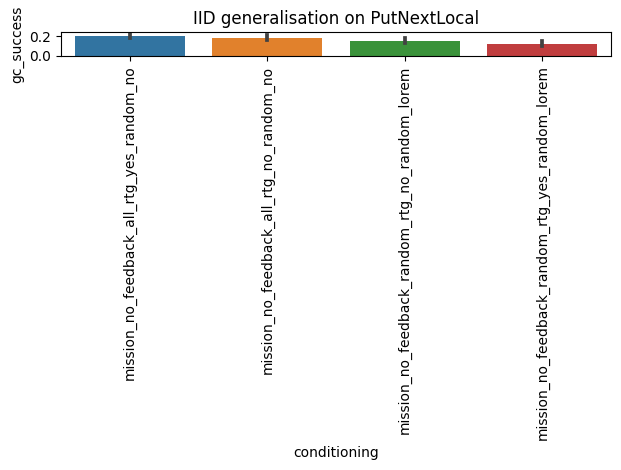

SAVED FIG


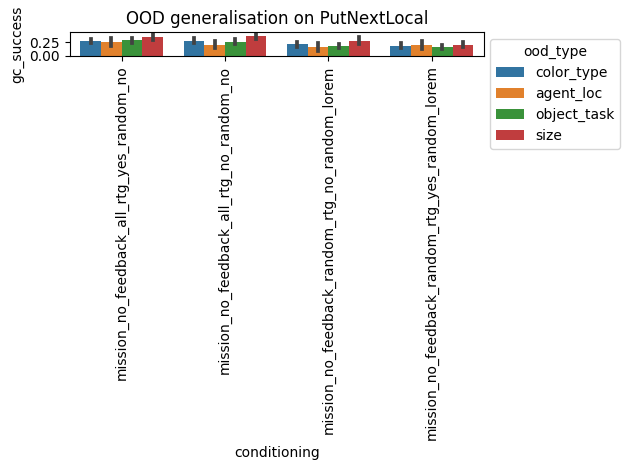

SAVED FIG


,Mean,Std,Min,Max
conditioning,,,,
mission_no_feedback_all_rtg_yes_random_no,0.206380,0.230404,0.0,1.00
mission_no_feedback_all_rtg_no_random_no,0.184896,0.225626,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,0.155273,0.204272,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,0.120117,0.189104,0.0,0.75


CREATED TABLE IN CSV
Results by seed


,,Mean,Std,Min,Max
conditioning,seed,,,,
mission_no_feedback_all_rtg_yes_random_no,987654321,0.216797,0.229196,0.0,1.00
mission_no_feedback_all_rtg_no_random_no,987654321,0.212891,0.245210,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,987654321,0.099609,0.183845,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,123456789,0.216797,0.227038,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,123456789,0.179688,0.214938,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,123456789,0.140625,0.192758,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,123456789,0.140625,0.192758,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,111111111,0.185547,0.235288,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,111111111,0.169922,0.214929,0.0,0.75


,Mean,Std,Min,Max
conditioning,,,,
mission_no_feedback_all_rtg_yes_random_no,0.292318,0.254207,0.0,1.00
mission_no_feedback_all_rtg_no_random_no,0.283203,0.249093,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,0.211914,0.219770,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,0.182617,0.218283,0.0,1.00


CREATED TABLE IN CSV


,,Mean,Std,Min,Max
conditioning,ood_type,,,,
mission_no_feedback_all_rtg_no_random_no,size,0.362069,0.252196,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,size,0.341954,0.250334,0.0,1.00
mission_no_feedback_random_rtg_no_random_lorem,size,0.280172,0.224964,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,size,0.206897,0.215302,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,object_task,0.285417,0.277473,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,object_task,0.262500,0.242211,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,object_task,0.178125,0.199659,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,object_task,0.156250,0.200375,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,color_type,0.278409,0.252181,0.0,0.75


CREATED TABLE IN CSV


,,Mean,Std,Min,Max
conditioning,ood_type,,,,
mission_no_feedback_all_rtg_no_random_no,size,0.362069,0.252196,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,size,0.341954,0.250334,0.0,1.00
mission_no_feedback_random_rtg_no_random_lorem,size,0.280172,0.224964,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,size,0.206897,0.215302,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,object_task,0.285417,0.277473,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,object_task,0.262500,0.242211,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,object_task,0.178125,0.199659,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,object_task,0.156250,0.200375,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,color_type,0.278409,0.252181,0.0,0.75


CREATED TABLE IN CSV


,,Mean,Std,Min,Max
conditioning,ood_type,,,,
mission_no_feedback_all_rtg_no_random_no,size,0.362069,0.252196,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,size,0.341954,0.250334,0.0,1.00
mission_no_feedback_random_rtg_no_random_lorem,size,0.280172,0.224964,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,size,0.206897,0.215302,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,object_task,0.285417,0.277473,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,object_task,0.262500,0.242211,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,object_task,0.178125,0.199659,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,object_task,0.156250,0.200375,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,color_type,0.278409,0.252181,0.0,0.75


CREATED TABLE IN CSV


,,Mean,Std,Min,Max
conditioning,ood_type,,,,
mission_no_feedback_all_rtg_no_random_no,size,0.362069,0.252196,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,size,0.341954,0.250334,0.0,1.00
mission_no_feedback_random_rtg_no_random_lorem,size,0.280172,0.224964,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,size,0.206897,0.215302,0.0,0.75
mission_no_feedback_all_rtg_yes_random_no,object_task,0.285417,0.277473,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,object_task,0.262500,0.242211,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,object_task,0.178125,0.199659,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,object_task,0.156250,0.200375,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,color_type,0.278409,0.252181,0.0,0.75


CREATED TABLE IN CSV
Results by seed


,,Mean,Std,Min,Max
conditioning,seed,,,,
mission_no_feedback_all_rtg_yes_random_no,987654321,0.316406,0.253876,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,987654321,0.292969,0.239153,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,987654321,0.189453,0.236331,0.0,1.00
mission_no_feedback_all_rtg_yes_random_no,123456789,0.322266,0.253232,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,123456789,0.291016,0.240524,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,123456789,0.175781,0.199308,0.0,0.75
mission_no_feedback_random_rtg_yes_random_lorem,123456789,0.175781,0.199308,0.0,0.75
mission_no_feedback_all_rtg_no_random_no,111111111,0.265625,0.267590,0.0,0.75
mission_no_feedback_random_rtg_no_random_lorem,111111111,0.248047,0.233714,0.0,0.75


In [299]:
for experiment in EXPERIMENT_NAMES:
    DATA_HOME = f"{PROJECT_HOME}/data/{experiment}"
    OUTPUT = f"{DATA_HOME}/output"
    comb_df = get_combined_df(OUTPUT)
    for metric in METRICS:
        plot_levels(OUTPUT, PARAMS[experiment], metric, comb_df)
        make_tables(OUTPUT, PARAMS[experiment], metric, comb_df)